In [1]:
import sys
print(sys.version)

3.9.6 (tags/v3.9.6:db3ff76, Jun 28 2021, 15:26:21) [MSC v.1929 64 bit (AMD64)]


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import cv2
!pip install mat73


Defaulting to user installation because normal site-packages is not writeable


In [6]:
import numpy as np
import h5py

filename = 'C:/Users/ee20m/Documents/nyu_depth_v2_labeled.mat'

# Load the data from the .mat file using h5py
with h5py.File(filename, 'r') as f:
    X = np.array(f['images'])
    y = np.array(f['depths'])

# Save the training data as NumPy arrays
np.save('nyudepth_v2_x_train.npy', X)
np.save('nyudepth_v2_y_train.npy', y)


X = X.transpose((0, 2, 3, 1))

In [7]:
X.shape,y.shape

((1449, 640, 480, 3), (1449, 640, 480))

In [8]:
# resize the images to reduce memory usage
X_resized = np.zeros((X.shape[0], 320, 160, 3))
y_resized = np.zeros((y.shape[0], 320, 160))

for i in range(X.shape[0]):
    X_resized[i] = cv2.resize(X[i].transpose(1, 0, 2)[::-1, ...], (160, 320))
    y_resized[i] = cv2.resize(y[i].transpose(1, 0)[::-1, ...], (160, 320))



In [9]:
del X
del y

In [10]:
X_resized.shape,y_resized.shape

((1449, 320, 160, 3), (1449, 320, 160))

In [11]:
pip install scikit-learn


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [12]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_resized, y_resized, test_size=0.2, random_state=42)

print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)


(1159, 320, 160, 3) (1159, 320, 160)
(290, 320, 160, 3) (290, 320, 160)


In [13]:
del X_resized
del y_resized

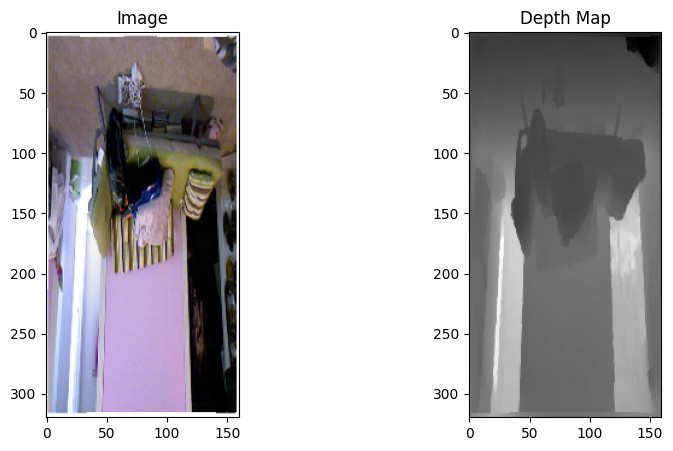

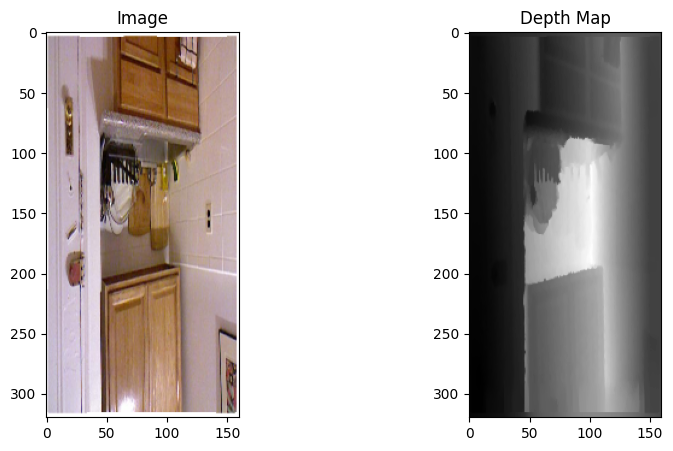

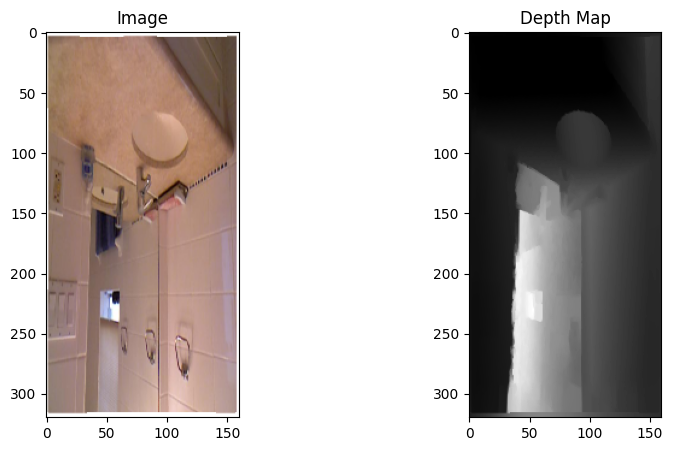

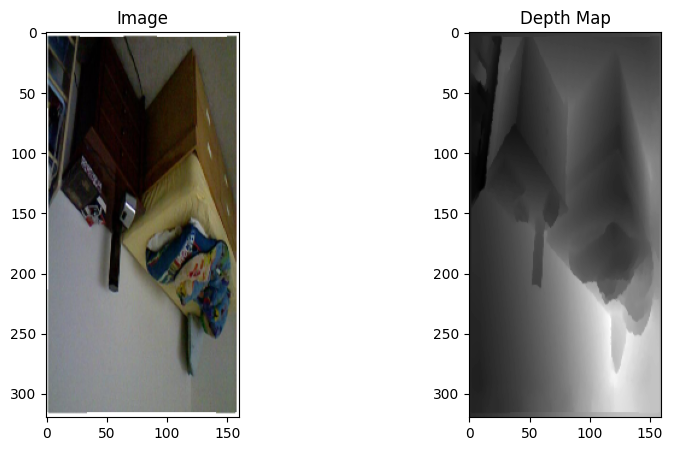

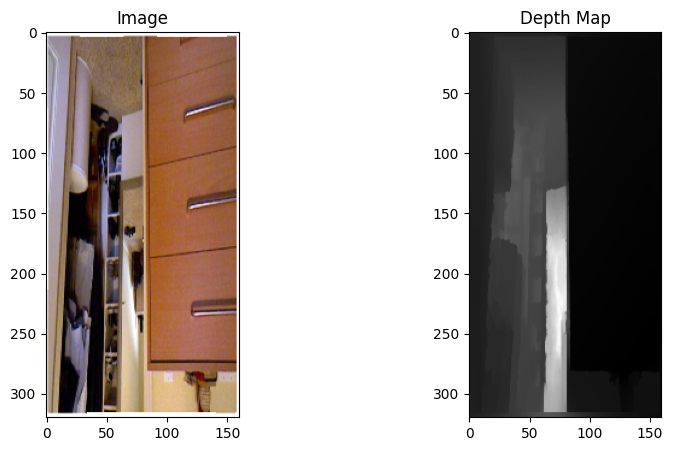

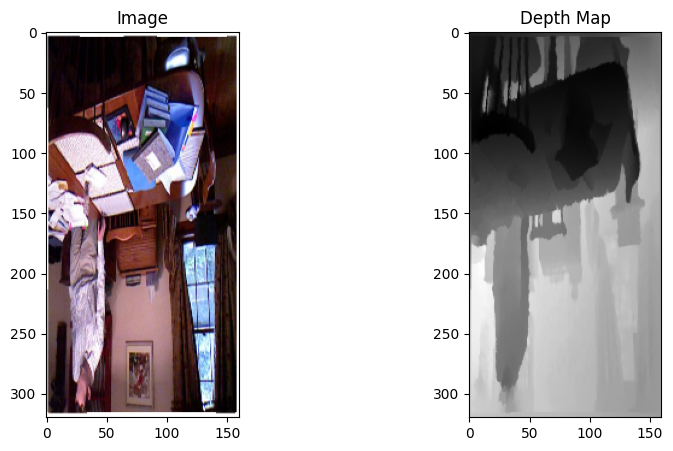

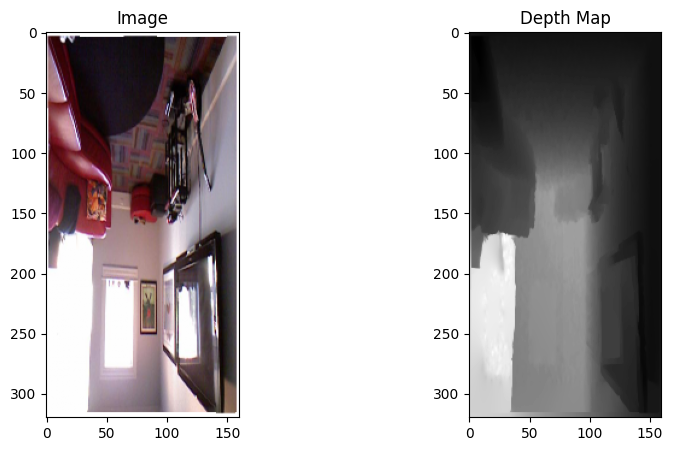

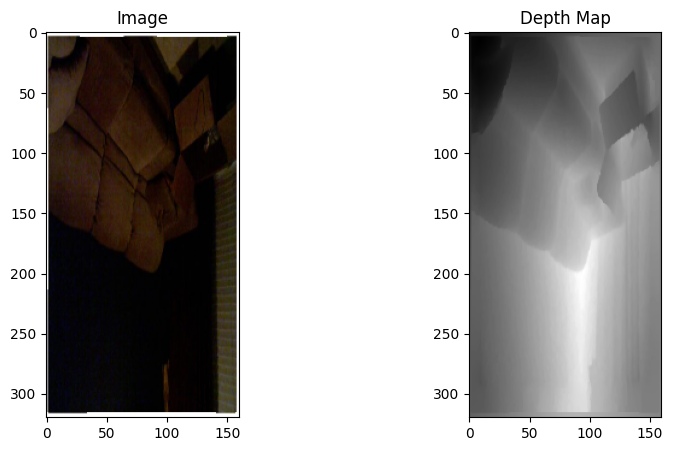

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# define a function to visualize an image with its corresponding depth map
def visualize_image_and_depth_map(X, y):
    # choose a random index
    idx = np.random.randint(X.shape[0])
    # get the image and depth map at that index
    image = X[idx]
    depth_map = y[idx]
    # normalize the pixel values to be between 0 and 1
    image = image / 255.0
    depth_map = depth_map / np.max(depth_map)
    # plot the image and depth map side by side
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)
    ax[0].set_title('Image')
    ax[1].imshow(depth_map, cmap='gray')
    ax[1].set_title('Depth Map')
    plt.show()


# visualize 4 random images from X_train
for i in range(4):
    visualize_image_and_depth_map(X_train, y_train)

# visualize 4 random images from X_val
for i in range(4):
    visualize_image_and_depth_map(X_val, y_val)


In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, concatenate
from tensorflow.keras.models import Model

def build_model(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(conv5)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

    # Decoder
    up6 = UpSampling2D(size=(2, 2))(pool5)
    up6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    up6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    up6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    merge6 = concatenate([conv5, up6], axis=3)

    up7 = UpSampling2D(size=(2, 2))(merge6)
    up7 = Conv2D(512, 3, activation='relu', padding='same')(up7)
    up7 = Conv2D(512, 3, activation='relu', padding='same')(up7)
    up7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    merge7 = concatenate([conv4, up7], axis=3)

    up8 = UpSampling2D(size=(2, 2))(merge7)
    up8 = Conv2D(256, 3, activation='relu', padding='same')(up8)
    up8 = Conv2D(256, 3, activation='relu', padding='same')(up8)
    up8 =Conv2D(128, 3, activation='relu', padding='same')(up8)
    merge8 = concatenate([conv3, up8], axis=3)

    up9 = UpSampling2D(size=(2, 2))(merge8)
    up9 = Conv2D(128, 3, activation='relu', padding='same')(up9)
    up9 = Conv2D(128, 3, activation='relu', padding='same')(up9)
    up9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    merge9 = concatenate([conv2, up9], axis=3)

    up10 = UpSampling2D(size=(2, 2))(merge9)
    up10 = Conv2D(64, 3, activation='relu', padding='same')(up10)
    up10 = Conv2D(64, 3, activation='relu', padding='same')(up10)
    up10 = Conv2D(1, 3, activation='sigmoid', padding='same')(up10)

    model = Model(inputs=inputs, outputs=up10)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model


In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from sklearn.model_selection import train_test_split




# Reshape the data

# Build the model
model = build_model(input_shape=X_train.shape[1:])


# Define a custom callback to print the loss after each epoch
class LossCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1} - loss: {logs['loss']:.4f} - val_loss: {logs['val_loss']:.4f}")

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True),
    LossCallback() # add custom callback
]

# Train model
history = model.fit(X_train, y_train, batch_size=8, epochs=30, validation_data=(X_val, y_val), callbacks=callbacks)


Epoch 1/30
145/145 [==============================] - 1835s 13s/step - loss: 5.1563 - mean_absolute_error: 1.8063 - val_loss: 5.2157 - val_mean_absolute_error: 1.8184
Epoch 2/30
145/145 [==============================] - 1581s 11s/step - loss: 5.1288 - mean_absolute_error: 1.8007 - val_loss: 5.2157 - val_mean_absolute_error: 1.8184
Epoch 3/30
145/145 [==============================] - 1103s 8s/step - loss: 5.1288 - mean_absolute_error: 1.8007 - val_loss: 5.2157 - val_mean_absolute_error: 1.8184
Epoch 4/30
145/145 [==============================] - 1512s 10s/step - loss: 5.1288 - mean_absolute_error: 1.8007 - val_loss: 5.2157 - val_mean_absolute_error: 1.8184
Epoch 5/30
145/145 [==============================] - 1731s 12s/step - loss: 5.1288 - mean_absolute_error: 1.8007 - val_loss: 5.2157 - val_mean_absolute_error: 1.8184
Epoch 6/30
145/145 [==============================] - 1736s 12s/step - loss: 5.1288 - mean_absolute_error: 1.8007 - val_loss: 5.2157 - val_mean_absolute_error: 1.8184

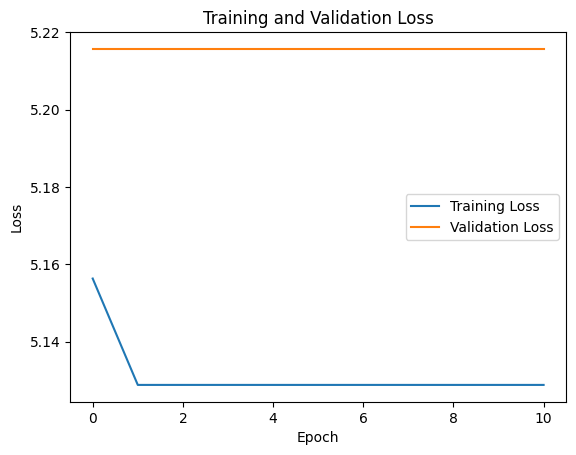

In [17]:
# Plot the training and validation loss for each epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
# Save the model
model.save()

print("Model saved successfully.")

TypeError: save() missing 1 required positional argument: 'filepath'

In [ ]:
# Select 5 random images from the validation set
random_indices = np.random.choice(range(len(X_val_processed)), size=5, replace=False)

# Generate depth map predictions for the selected indices
predictions = model.predict(X_valy[random_indices])

# Visualize the results
plt.figure(figsize=(15, 10))
for i, index in enumerate(random_indices):
    plt.subplot(3, 5, i + 1)
    plt.imshow(X_val[index])
    plt.title("Actual Image")

    plt.subplot(3, 5, i + 6)
    plt.imshow(y_val[index], cmap='gray')
    plt.title("Actual Depth Map")

    plt.subplot(3, 5, i + 11)
    plt.imshow(predictions[i].squeeze(), cmap='gray')
    plt.title("Predicted Depth Map")

plt.tight_layout()
plt.show()
model.save("~/advance_transformer_model")

# Now this is for Plain CNN Model to train

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the preprocessed data
X_train = np.load('nyudepth_v2_x_train.npy')
y_train = np.load('nyudepth_v2_y_train.npy')

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Train the model
history = model.fit(X_train, y_train, batch_size=8, epochs=100, validation_data=(X_val, y_val))

# Plot the training and validation loss for each epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
